In [1]:
! pip install pyspark

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, desc, col, max, struct, round, min
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from wordcloud import WordCloud
from textblob import TextBlob
import pandas as pd

In [3]:
spark = SparkSession.builder.appName('Spark_IMDB').getOrCreate()

In [4]:
# Load IMDB dataset
imdb_path="/content/Netflix TV Shows and Movies.csv"
imdb_df=spark.read.format('csv').option('inferSchema', True)\
        .option('header', True)\
        .option("multiline", "true")\
        .option("quote", '"')\
        .option("header", "true")\
        .option("escape", "\\")\
        .option("escape", '"').load(imdb_path)

imdb_df.show()

shape=(imdb_df.count(), len(imdb_df.columns))
print(shape)

imdb_df.printSchema()

+-----+--------+--------------------+-----+--------------------+------------+-----------------+-------+---------+-----------------+----------+
|index|      id|               title| type|         description|release_year|age_certification|runtime|  imdb_id|       imdb_score|imdb_votes|
+-----+--------+--------------------+-----+--------------------+------------+-----------------+-------+---------+-----------------+----------+
|    0| tm84618|         Taxi Driver|MOVIE|A mentally unstab...|        1976|                R|    113|tt0075314|              8.3|  795222.0|
|    1|tm127384|Monty Python and ...|MOVIE|King Arthur, acco...|        1975|               PG|     91|tt0071853|8.199999999999998|  530877.0|
|    2| tm70993|       Life of Brian|MOVIE|Brian Cohen is an...|        1979|                R|     94|tt0079470|              8.0|  392419.0|
|    3|tm190788|        The Exorcist|MOVIE|12-year-old Regan...|        1973|                R|    133|tt0070047|              8.1|  391942.0|

### 1. Distribution

In [5]:
# Group by type
query_type = imdb_df.select('type').groupby('type').\
      agg(count('*').alias('count')).toPandas()
# Group by age certification
query_age_cert = imdb_df.select('age_certification').groupby('age_certification').\
      agg(count('*').alias('count')).toPandas()
# Group by release year
query_year = imdb_df.select('release_year', 'type').groupby('release_year', 'type').\
      agg(count('*').alias('count')).toPandas()
# Group by release year
query_year_age = imdb_df.select('release_year', 'age_certification').groupby('release_year', 'age_certification').\
      agg(count('*').alias('count')).toPandas()

# Plot type
fig = go.Figure(data=[go.Pie(labels=query_type['type'], values=query_type['count'],
                             textinfo='label+percent',
                             insidetextorientation='radial')])
fig.show()
# Plot age certification
fig = px.pie(query_age_cert, values='count', names='age_certification')
fig.update_traces(textposition='outside', textinfo='percent+label',
                  hole=.6, hoverinfo="label+percent+name")
fig.update_layout(margin = dict(t=0, l=0, r=0, b=0),
                  annotations=[dict(text='Age Certification', showarrow=False)])
fig.show()
# Plot year
fig = px.bar(query_year, x="release_year", y="count", color="type", title="Release Year")\
          .update_layout(xaxis_title="Release Year", yaxis_title="Count")

fig.show()
fig = px.bar(query_year_age, x="release_year", y="count", color="age_certification", title="Release Year")\
          .update_layout(xaxis_title="Release Year", yaxis_title="Count")

fig.show()

In [6]:
# Type and Age Cert Distribution
query_type_age = imdb_df.select('type', 'age_certification').where('age_certification is not null').groupby('age_certification', 'type').\
      agg(count('*').alias('count')).toPandas()

fig = px.bar(query_type_age, x='age_certification', y='count', color='type', text_auto=True)\
          .update_layout(xaxis_title="Age Certification", yaxis_title="Count")
fig.show()

### 2. IMDB Score

In [7]:
# Score of both types and counts
query_score = imdb_df.select('imdb_score', 'type').groupby('imdb_score', 'type').\
      agg(count('*').alias('count')).toPandas()
# Rounded score of both types and counts
query_score_round = imdb_df.select('imdb_score', 'type').groupby(round('imdb_score', 0), 'type').\
      agg(count('*').alias('count')).toPandas()

fig = px.scatter(query_score, x="imdb_score", y="count", color='type')\
            .update_layout(xaxis_title="IMDB Score", yaxis_title="Count")
fig.show()

fig = px.bar(query_score_round, x='round(imdb_score, 0)', y="count", color='type',
             barmode='group', text_auto=True)\
            .update_layout(xaxis_title="Rounded IMDB Score", yaxis_title="Count")
fig.show()

In [8]:
# Top 20
query_top = imdb_df.select('title', 'imdb_score', 'type').orderBy(desc('imdb_score')).\
      limit(20).toPandas()
# Recent 5 years' top 3
years = [2022, 2021, 2020, 2019, 2018]
query_top_3 = pd.DataFrame(columns=['title', 'imdb_score', 'type', 'release_year'])
for year in years:
  query_top_3 = pd.concat([query_top_3, imdb_df.select('title', 'imdb_score', 'type', 'release_year').where('release_year==' + str(year)).\
              orderBy(desc('imdb_score')).limit(3).toPandas()])
fig = px.bar(query_top, x="imdb_score", y="title", orientation='h', text_auto=True,
             color='type')\
        .update_layout(xaxis_title="IMDB Score", yaxis_title="Title")
fig.show()

fig = px.sunburst(query_top_3, path=['release_year', 'type', 'title'], values=query_top_3['imdb_score'],
                  color=query_top_3['imdb_score'],
                  color_continuous_scale='orrd',
                  color_continuous_midpoint=np.average(query_top_3['imdb_score']))
fig.show()

In [9]:
query_score_per_age = imdb_df.groupBy('age_certification').agg(max('imdb_score'), min('imdb_score')).toPandas()

fig = go.Figure(
    data=[
        go.Scatter(
            x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            y=query_score_per_age['age_certification'],
            mode="text",
            showlegend=False,
            marker=dict(
                color="grey"
            )
        ),
        go.Scatter(
            x=query_score_per_age['min(imdb_score)'],
            y=query_score_per_age['age_certification'],
            mode="markers",
            name="Min IMDB Score",
            marker=dict(
                color="silver",
                size=10
            )

        ),
        go.Scatter(
            x=query_score_per_age['max(imdb_score)'],
            y=query_score_per_age['age_certification'],
            mode="markers",
            name="Max IMDB Score",
            marker=dict(
                color="lightskyblue",
                size=10
            )
        ),
    ]
)

fig.update_layout(
    title="Min and Max IMDB Score for Each Age Certification",
    height=800,
    legend_itemclick=False
)

fig.show()


query_score_per_year = imdb_df.groupBy('release_year').agg(max('imdb_score'), min('imdb_score')).toPandas()

fig = go.Figure(
    data=[
        go.Scatter(
            x=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
            y=query_score_per_year['release_year'],
            mode="text",
            showlegend=False,
            marker=dict(
                color="grey"
            )
        ),
        go.Scatter(
            x=query_score_per_year['min(imdb_score)'],
            y=query_score_per_year['release_year'],
            mode="markers",
            name="Min IMDB Score",
            marker=dict(
                color="silver",
                size=10
            )

        ),
        go.Scatter(
            x=query_score_per_year['max(imdb_score)'],
            y=query_score_per_year['release_year'],
            mode="markers",
            name="Max IMDB Score",
            marker=dict(
                color="lightskyblue",
                size=10
            )
        ),
    ]
)

fig.update_layout(
    title="Min and Max IMDB Score for Each Release Year",
    height=1000,
    legend_itemclick=False
)

fig.show()

In [10]:
# Score and runtime
query_score_runtime = imdb_df.select('runtime', 'imdb_score', 'type').groupby('runtime', 'imdb_score', 'type').\
      agg(count('*').alias('count')).toPandas()
# Score and release year
query_score_year = imdb_df.select('release_year', 'imdb_score', 'type').groupby('release_year', 'imdb_score', 'type').\
      agg(count('*').alias('count')).toPandas()
# Score and age certification
query_score_age = imdb_df.select('age_certification', 'imdb_score', 'type').groupby('age_certification', 'imdb_score', 'type').\
      agg(count('*').alias('count')).toPandas()
# release year and runtime
query_year_runtime = imdb_df.select('release_year', 'runtime', 'type').groupby('release_year', 'runtime', 'type').\
      agg(count('*').alias('count')).toPandas()

fig = px.scatter(query_score_runtime, x="imdb_score", y="runtime", color="type",
                 size='count', hover_data=['count'])\
                 .update_layout(xaxis_title="IMDB Score", yaxis_title="Runtime")
fig.show()
fig = px.scatter(query_score_year, x="imdb_score", y="release_year", color="type",
                 size='count', hover_data=['count'])\
                 .update_layout(xaxis_title="IMDB Score", yaxis_title="Year")
fig.show()
fig = px.scatter(query_score_age, x="imdb_score", y="age_certification", color="type",
                 size='count', hover_data=['count'])\
                 .update_layout(xaxis_title="IMDB Score", yaxis_title="Age Ceertification")
fig.show()
fig = px.scatter(query_year_runtime, x="release_year", y="runtime", color="type",
                 size='count', hover_data=['count'])\
                 .update_layout(xaxis_title="Year", yaxis_title="Runtime")
fig.show()

In [13]:
# 3 dimensions with runtime, score and release year
query_3d = imdb_df.select('release_year', 'imdb_score', 'runtime').toPandas()

fig = go.Figure(data=[go.Mesh3d(x=query_3d['release_year'],
                   y=query_3d['imdb_score'],
                   z=query_3d['runtime'],
                   opacity=0.5,
                   color='pink'
                  )])

fig.update_layout(
    scene = dict(
        xaxis = dict(nticks=4),
                     yaxis = dict(nticks=4),
                     zaxis = dict(nticks=4),
        xaxis_title="Year", yaxis_title="IMDB Score", zaxis_title="Runtime"),
    width=700,
    margin=dict(r=20, l=10, b=10, t=10))

fig.show()

### 3. Description

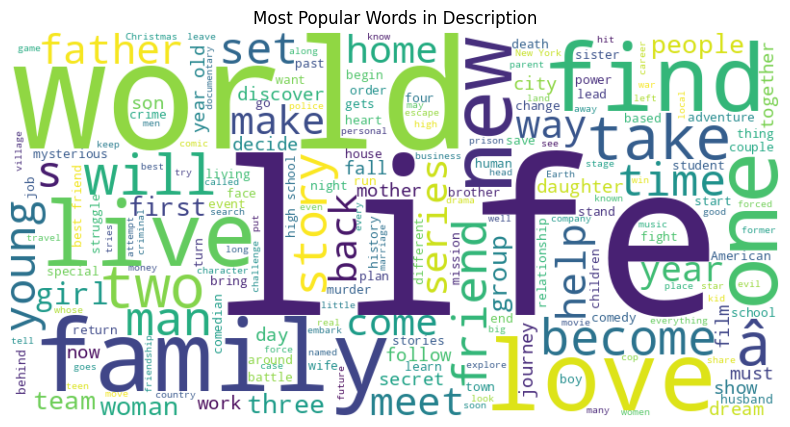

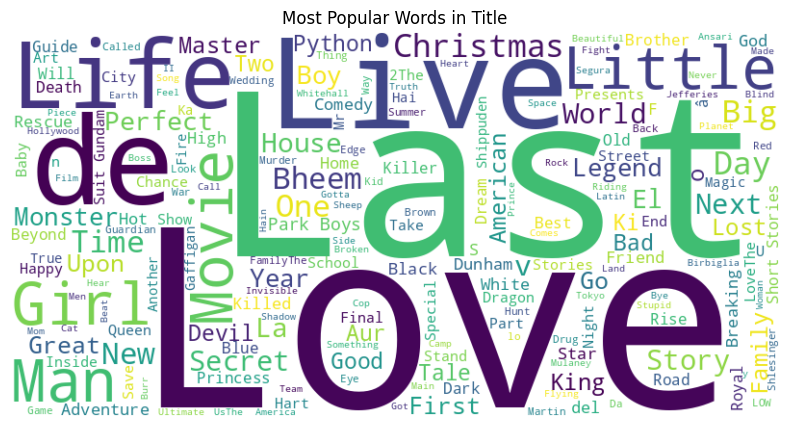

In [12]:
whole_text = ""
for text in imdb_df.select('description').toPandas()['description']:
  if text is not None:
    whole_text += text

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(whole_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Popular Words in Description')
plt.show()

whole_text = ""
for text in imdb_df.select('title').toPandas()['title']:
  if text is not None:
    whole_text += text

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(whole_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Most Popular Words in Title')
plt.show()